#  Read Data

In [3]:
import pandas as pd
import numpy as np
train_data = pd.read_csv('../data/full_size/atec_anti_fraud_train.csv',index_col = 0)
testa_data = pd.read_csv('../data/full_size/atec_anti_fraud_test_a.csv',index_col = 0)

# Get filldable features

In [4]:
# find no missing value features
no_nan_features = []
i = 0
while i<len(testa_data.columns):
    name = testa_data.columns[i]
    if train_data[name].isnull().sum()==0:
        no_nan_features.append(name)
    i+=1

In [5]:
# find small missing features
small_missing_features=[]
i = 1
while i<len(testa_data.columns):
    name = testa_data.columns[i]
    train_missing_rate = train_data[name].isnull().sum()/train_data.shape[0]
    test_missing_rate = testa_data[name].isnull().sum()/testa_data.shape[0]
    if 0<train_missing_rate<0.3 and abs(test_missing_rate-train_missing_rate)<0.1:
        small_missing_features.append(name)
    i+=1

# Split data into normal and anormal

In [ ]:
normal_data = train_data[train_data['label']==0]
anormal_data = train_data[train_data['label']==1]

normal_train_num = int(normal_data.shape[0]*0.8)
normal_test_num = int(normal_data.shape[0]*0.1)
normal_valid_num = normal_data.shape[0]-normal_train_num-normal_test_num

anormal_test_num = int(anormal_data.shape[0]*0.5)
anormal_valid_num = anormal_data.shape[0]-anormal_test_num

normal_train_x = normal_data.iloc[:normal_train_num,1:]
normal_valid_x = normal_data.iloc[normal_train_num:normal_train_num+normal_valid_num,1:]
normal_valid_y = normal_data.iloc[normal_train_num:normal_train_num+normal_valid_num,0]
normal_test_x = normal_data.iloc[normal_train_num+normal_valid_num:,1:]
normal_test_y = normal_data.iloc[normal_train_num+normal_valid_num:,0]

anormal_valid_x = anormal_data.iloc[:anormal_valid_num,1:]
anormal_valid_y = anormal_data.iloc[:anormal_valid_num,0]
anormal_test_x = anormal_data.iloc[anormal_valid_num:,1:]
anormal_test_y = anormal_data.iloc[anormal_valid_num:,0]

valid_x = normal_valid_x.append(anormal_valid_x)
valid_y = normal_valid_y.append(anormal_valid_y)
test_x = normal_test_x.append(anormal_test_x)
test_y = normal_test_y.append(anormal_test_y)

# Define evaluation function

In [6]:
def ant_score(truth,score):
    FNR1 = 0.001
    FNR2 = 0.005
    FNR3 = 0.01
    min1 = min2 = min3 = 1
    for thr in np.arange(0,1+0.001,0.001):
        evaluate_table = pd.DataFrame({'truth':truth,'score':score})
        evaluate_table.loc[evaluate_table['score']>=thr,'score']=1
        evaluate_table.loc[evaluate_table['score']<thr,'score']=0
        TP = evaluate_table.loc[(evaluate_table['score']==1)&(evaluate_table['truth']==1)].shape[0]
        FN = evaluate_table.loc[(evaluate_table['score']==0)&(evaluate_table['truth']==1)].shape[0]
        TN = evaluate_table.loc[(evaluate_table['score']==0)&(evaluate_table['truth']==0)].shape[0]
        FP = evaluate_table.loc[(evaluate_table['score']==1)&(evaluate_table['truth']==0)].shape[0]
        TPR = TP/(TP+FN)
        FNR = FP/(TN+FP)
        if abs(FNR-FNR1)<min1:
            min1 = abs(FNR-FNR1)
            FNR11 = FNR
            TPR1 = TPR
        if abs(FNR-FNR2)<min2:
            min2 = abs(FNR-FNR2)
            FNR22 = FNR
            TPR2 = TPR
        if abs(FNR-FNR3)<min3:
            min3 = abs(FNR-FNR3)
            FNR33 = FNR
            TPR3 = TPR
    return (0.4*TPR1+0.3*TPR2+0.3*TPR3,FNR11,FNR22,FNR33)

# Try visual clustering using kmeans

In [7]:
from sklearn.cluster import KMeans
# prepare subset of data
sample_data = train_data[train_data['label']!=-1].drop(columns=['label'])
sample_data = sample_data[no_nan_features+small_missing_features]
sample_data.fillna(sample_data.mean(),inplace=True)

## Build and fit kmeans model

In [8]:
clustering = KMeans(n_clusters=2)
clustering.fit(sample_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pca = PCA(n_components=3).fit(sample_data)
sample_data2d = pca.transform(sample_data)

In [10]:
labels = train_data[train_data['label']!=-1]['label']

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sample_data2d[:,0],sample_data2d[:,1],sample_data2d[:,2],c=labels.astype(float))
plt.title("Ground truth")
# plt.subplot(1,2,2)
# plt.scatter(sample_data2d[:10000,0],sample_data2d[:10000,1],sample_data2d[:10000,2],c=clustering.labels_[:10000].astype(float))
# plt.title("Kmeans result")
plt.show()

In [1]:
print(pd.Series(labels[:10000]).value_counts())
print(pd.Series(clustering.labels_[:10000]).value_counts())

NameError: name 'pd' is not defined

In [37]:
from sklearn.metrics import precision_score,recall_score
pre_score = precision_score(labels[:10000],clustering.labels_[:10000])
rec_score = recall_score(labels[:10000],clustering.labels_[:10000])
print(pre_score,rec_score)

0.0 0.0


# 1. Gaussian based semi-supervised model

## 1.1 Handling missing values

In [38]:
# gaussian model
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

imputer = Imputer(strategy='mean')
scaler = StandardScaler()
normal_train_x = imputer.fit_transform(normal_train_x.loc[:,no_nan_features+small_missing_features])
normal_train_x = scaler.fit_transform(normal_train_x)
normal_valid_x = imputer.fit_transform(normal_valid_x.loc[:,no_nan_features+small_missing_features])
normal_valid_x = scaler.fit_transform(normal_valid_x)
anormal_valid_x = scaler.fit_transform(imputer.fit_transform(anormal_valid_x.loc[:,no_nan_features+small_missing_features]))

-16.90444455367482
-21.49116167759294


## 1.2 Get mu and sigma of Gaussian Distribution

In [ ]:
mu = normal_train_x.mean(axis=0)
sigma = pd.DataFrame(normal_train_x).cov()
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

## 1.3 Get average distance result in valid dataset

In [ ]:
print(np.median(model.logpdf(normal_valid_x)))
print(np.median(model.logpdf(anormal_valid_x))) 

# 2. Isolation Forest

## 2.1 Build Model

In [184]:
# isolation forest model
from sklearn.ensemble import IsolationForest
np.random.seed(42)

model = IsolationForest(random_state=42,max_samples=new_normal_train_x.shape[0], bootstrap=True, n_estimators=50)
model.fit(new_normal_train_x)

0.10782184916058435
0.0677083113482714


## 2.2 Get mean score of normal and anormal data

In [190]:
print(model.decision_function(new_normal_valid_x).mean())
print(model.decision_function(new_anormal_valid_x).mean())

0.15212544974077724
-0.20261464142587504


## 2.3 Tune threshold in valid dataset

In [191]:
# tune threshold
from sklearn.metrics import recall_score,precision_score,fbeta_score
thresholds = np.linspace(-0.2,0.2,200)
y_scores = model.decision_function(new_valid_x)
scores=[]
for threshold in thresholds:
    y_hat = (y_scores < threshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid_y.values),
                 precision_score(y_pred=y_hat, y_true=valid_y.values),
                 fbeta_score(y_pred=y_hat, y_true=valid_y.values, beta=2)])

## 2.4 Get Best threshold

In [192]:
scores = np.array(scores)
print(scores[:,2].max(),scores[:,2].argmax())

0.2854756186697296 150


## 2.5 Plot result

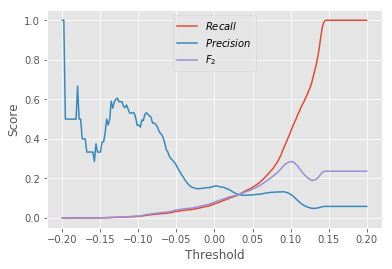

In [193]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
plt.plot(thresholds, scores[:, 0], label='$Recall$')
plt.plot(thresholds, scores[:, 1], label='$Precision$')
plt.plot(thresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

## 2.6 Prediction on test set using best threshold

In [168]:
best_thr = thresholds[scores[:,2].argmax()]
y_scores = model.decision_function(imputer.fit_transform(test_x.loc[:,no_nan_features+small_missing_features]))
y_hat = (y_scores < best_thr).astype(int)
print(precision_score(y_pred=y_hat, y_true=test_y.values),
      recall_score(y_pred=y_hat, y_true=test_y.values),
    fbeta_score(y_pred=y_hat, y_true=test_y.values, beta=2))

0.10744059699628439 0.5677280976736512 0.3057525190595511
